In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def rgb_to_xyz(rgb):
    """Convert RGB to XYZ color space."""
    M = np.array([[0.4124564, 0.3575761, 0.1804375],
                  [0.2126729, 0.7151522, 0.0721750],
                  [0.0193339, 0.1191920, 0.9503041]])
    return np.dot(rgb, M.T)

def xyz_to_lms(xyz):
    """Convert XYZ to LMS color space."""
    M = np.array([[0.4002, 0.7075, -0.0808],
                  [-0.2263, 1.1653, 0.0457],
                  [0.0000, 0.0000, 0.9182]])
    return np.dot(xyz, M.T)

def lms_to_lab(lms):
    """Convert LMS to lαβ color space."""
    lms = np.where(lms > 0, np.log(lms), 0)  # Apply log transformation
    M = np.array([[1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)],
                  [1/np.sqrt(6), 1/np.sqrt(6), -2/np.sqrt(6)],
                  [1/np.sqrt(2), -1/np.sqrt(2), 0]])
    return np.dot(lms, M.T)

def lab_to_lms(lab):
    """Convert lαβ to LMS color space."""
    M_inv = np.array([[1/np.sqrt(3), 1/np.sqrt(6), 1/np.sqrt(2)],
                      [1/np.sqrt(3), 1/np.sqrt(6), -1/np.sqrt(2)],
                      [1/np.sqrt(3), -2/np.sqrt(6), 0]])
    lms = np.dot(lab, M_inv.T)
    return np.exp(lms)  # Inverse log

def lms_to_xyz(lms):
    """Convert LMS to XYZ color space."""
    M_inv = np.array([[1.8601, -1.1295, 0.2199],
                      [0.3612, 0.6388, -0.0000],
                      [0.0000, 0.0000, 1.0891]])
    return np.dot(lms, M_inv.T)

def xyz_to_rgb(xyz):
    """Convert XYZ to RGB color space."""
    M_inv = np.array([[3.2404542, -1.5371385, -0.4985314],
                      [-0.9692660, 1.8760108, 0.0415560],
                      [0.0556434, -0.2040259, 1.0572252]])
    rgb = np.dot(xyz, M_inv.T)
    return np.clip(rgb, 0, 1)  # Ensure values are in valid range

def color_transfer(source, target):
    """Perform color transfer from target image to source image."""
    source = source.astype(np.float32) / 255.0
    target = target.astype(np.float32) / 255.0

    # Convert images to lαβ space
    source_lab = lms_to_lab(xyz_to_lms(rgb_to_xyz(source)))
    target_lab = lms_to_lab(xyz_to_lms(rgb_to_xyz(target)))

    # Compute mean and std for source and target
    mean_s, std_s = np.mean(source_lab, axis=(0,1)), np.std(source_lab, axis=(0,1))
    mean_t, std_t = np.mean(target_lab, axis=(0,1)), np.std(target_lab, axis=(0,1))

    # Normalize source image and match target statistics
    result_lab = (source_lab - mean_s) * (std_t / std_s) + mean_t

    # Convert back to RGB
    result_rgb = xyz_to_rgb(lms_to_xyz(lab_to_lms(result_lab)))

    return (result_rgb * 255).astype(np.uint8)



/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [6]:
# Load images
source_img = cv2.cvtColor(cv2.imread(r"/home/neelraj-reddy/college/6th_sem/computer vision/project/A little survey on previous works/images/beach_target.jpeg"), cv2.COLOR_BGR2RGB)
target_img = cv2.cvtColor(cv2.imread(r"/home/neelraj-reddy/college/6th_sem/computer vision/project/A little survey on previous works/images/beach_ref.jpg"), cv2.COLOR_BGR2RGB)

# Apply color transfer
result_img = color_transfer(target_img,source_img)



/tmp/ipykernel_72829/2796932772.py:21: RuntimeWarning: divide by zero encountered in log
  lms = np.where(lms > 0, np.log(lms), 0)  # Apply log transformation


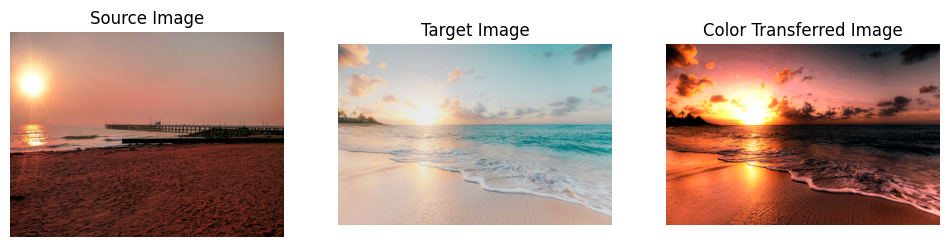

In [7]:
# Show results
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(source_img)
ax[0].set_title("Source Image")
ax[0].axis("off")

ax[1].imshow(target_img)
ax[1].set_title("Target Image")
ax[1].axis("off")

ax[2].imshow(result_img)
ax[2].set_title("Color Transferred Image")
ax[2].axis("off")

plt.show()


## **3. Handling Multiple Color Clusters**
The paper also notes that simple mean-variance matching might fail if:
- The source and target images have **different dominant colors** (e.g., source has a lot of grass, target has more sky).
- The method assumes **global** color statistics, but colors may vary across different regions.

### **Solution: Cluster-Based Color Matching**
- Instead of treating the whole image as one unit, the image can be split into **clusters** (e.g., sky, grass).
- Compute **mean and standard deviation** for each cluster separately.
- Assign each pixel in the source image to the **nearest cluster** in the target image using **normalized distances**.
- Blend color-mapped pixels using weights **inversely proportional to distance** from cluster centers.

This **localized approach** improves quality when the images contain **different regions with different color distributions**.


/tmp/ipykernel_72829/2796932772.py:21: RuntimeWarning: divide by zero encountered in log
  lms = np.where(lms > 0, np.log(lms), 0)  # Apply log transformation


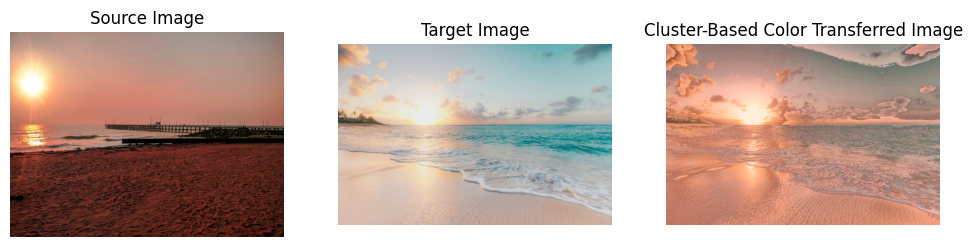

In [8]:
from sklearn.cluster import KMeans

def cluster_color_transfer(source, target, n_clusters=3):
    """Perform color transfer using K-Means clustering."""
    source = source.astype(np.float32) / 255.0
    target = target.astype(np.float32) / 255.0

    # Convert images to lαβ space
    source_lab = lms_to_lab(xyz_to_lms(rgb_to_xyz(source.reshape(-1, 3))))
    target_lab = lms_to_lab(xyz_to_lms(rgb_to_xyz(target.reshape(-1, 3))))

    # Apply K-Means clustering
    kmeans_source = KMeans(n_clusters=n_clusters, n_init=10).fit(source_lab)
    kmeans_target = KMeans(n_clusters=n_clusters, n_init=10).fit(target_lab)

    source_labels = kmeans_source.labels_
    target_labels = kmeans_target.labels_
    source_centers = kmeans_source.cluster_centers_
    target_centers = kmeans_target.cluster_centers_

    # Match clusters based on Euclidean distance
    matched_clusters = {}
    for i, src_center in enumerate(source_centers):
        closest_cluster = np.argmin(np.linalg.norm(target_centers - src_center, axis=1))
        matched_clusters[i] = closest_cluster

    # Apply color transfer per cluster
    result_lab = np.zeros_like(source_lab)
    for src_cluster, tgt_cluster in matched_clusters.items():
        src_mask = source_labels == src_cluster
        tgt_mask = target_labels == tgt_cluster

        mean_s, std_s = source_lab[src_mask].mean(axis=0), source_lab[src_mask].std(axis=0)
        mean_t, std_t = target_lab[tgt_mask].mean(axis=0), target_lab[tgt_mask].std(axis=0)

        # Normalize and match target statistics
        result_lab[src_mask] = (source_lab[src_mask] - mean_s) * (std_t / std_s) + mean_t

    # Convert back to RGB
    result_rgb = xyz_to_rgb(lms_to_xyz(lab_to_lms(result_lab.reshape(source.shape))))

    return (result_rgb * 255).astype(np.uint8)

# Apply cluster-based color transfer
cluster_result = cluster_color_transfer(target_img,source_img,  n_clusters=3)

# Show results
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(source_img)
ax[0].set_title("Source Image")
ax[0].axis("off")

ax[1].imshow(target_img)
ax[1].set_title("Target Image")
ax[1].axis("off")

ax[2].imshow(cluster_result)
ax[2].set_title("Cluster-Based Color Transferred Image")
ax[2].axis("off")

plt.show()


# Cluster-Based vs. Global Statistical Approach in Color Transfer

## Why Can the Cluster-Based Approach Produce Poorer Results?

### 1. Cluster Mismatch
- If the K-Means clusters in the source and target images don’t align well (e.g., sky in one image is matched to grass in another), the transformation will be incorrect.
- The global statistical approach applies a uniform transformation, avoiding this issue.

### 2. Loss of Color Consistency
- Since different clusters are transformed independently, sharp color boundaries may appear, making the result look unnatural.
- The global approach applies the same transformation to all pixels, maintaining smooth transitions.

### 3. K-Means Instability
- K-Means can assign different labels each time due to randomness in initialization.
- If the clusters shift slightly between runs, results may be inconsistent.

### 4. Inadequate Cluster Representation
- If `k` (the number of clusters) is too small, colors may not be properly separated.
- If `k` is too large, noise may increase, reducing the effectiveness of color transfer.

### 5. Blending Issues
- The blending of clusters using inverse distance weighting might not work well when colors are very different between images.
- This can lead to colors being washed out or overly saturated.

---

## When is the Cluster-Based Method Useful?
- Works best when both images contain **similar objects in similar locations** (e.g., faces, buildings, forests).
- Useful when **different parts of the image need different transformations** (e.g., sky and grass should be treated separately).


# We process in **LAB (or similar perceptual color spaces like lαβ)** instead of RGB because:  

1. **Perceptual Uniformity**  
   - In LAB, small changes in values correspond to roughly equal perceptual changes in color.  
   - In RGB, similar numerical changes can appear very different visually.  

2. **Better Color Decorrelation**  
   - The **L** channel represents lightness, while **A** and **B** represent color components.  
   - This separation makes it easier to adjust colors without affecting brightness.  
   - In RGB, Red, Green, and Blue are highly correlated, making direct color adjustments harder.  

3. **Better for Statistics-Based Processing**  
   - Color transfer works by matching **mean and standard deviation** of color distributions.  
   - LAB’s uncorrelated channels make statistical matching more meaningful.  

4. **Human Vision Similarity**  
   - LAB models colors similar to how humans perceive them.  
   - RGB is device-dependent, meaning it varies based on screen and lighting conditions.  

This is why most **color transfer, color grading, and style transfer** methods first convert images to LAB or similar spaces before processing.